In [230]:
### - import all the usual stuff - ###

import sys
sys.path.append('../../mist-base/GW')
sys.path.append('../../mist-base/')
sys.path.append('../../mist-base/utils')
sys.path.append('../../')

import gw150814_simulator as gs
from gw150814_simulator import GW150814, defaults, GW150814_Additive
# import module

import torch
torch.set_float32_matmul_precision('medium')
import numpy as np
import scipy
from scipy.signal import welch
from scipy.ndimage import uniform_filter1d
import scipy.stats
import pytorch_lightning as pl
from collections import defaultdict
from tqdm import tqdm
import jax.numpy as jnp
import plotfancy as pf
pf.housestyle_rcparams()

from gwosc.datasets import event_gps
from gwpy.timeseries import TimeSeries

from ipywidgets import interactive_output, VBox, HBox, FloatSlider, Checkbox, FloatLogSlider, FloatRangeSlider, FloatText, IntSlider
import sounddevice as sd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import os, sys

from simulators.additive import Simulator_Additive
from simulators.utils import *
from utils.data import OnTheFlyDataModule, StoredDataModule
from utils.module import CustomLossModule_withBounds, BCELossModule

In [287]:
class Comb3:
    def __init__(self, waveform, timespace, ampscale=10**2, inject=True):
        assert len(waveform) == len(timespace), 'Waveform and Waveform Time Domain must be same length!!'
        
        self.asc = ampscale
        self.length = len(waveform)

        self.w_TD_data = waveform
        self.w_TD_times = timespace

        if inject:
            self.inject_comb_stoch(waveform,timespace)
        else:
            self.load_FD(waveform,timespace)

    def load_FD(self, wf,ts):
        self.w_FD_data = np.fft.rfft(wf)
        self.w_FD_freqs = np.fft.rfftfreq(len(wf), d=np.mean(np.diff(ts)))
        self.w_FD_df = np.mean(np.diff(ts))
    
    def _inject_comb(self,wf,ts, f0,df,nf):
        global base
        base = np.zeros(len(self.w_FD_data))
        comb_freqs = np.arange(nf)*df+f0
        global indices
        indices = np.argmin(np.abs(self.w_FD_freqs[:, np.newaxis] - comb_freqs[np.newaxis, :]), axis=0)
        
        smooth = uniform_filter1d(np.abs(np.real(self.w_FD_data)), size=10)

        # f_values = np.abs(np.real(self.w_FD_data[indices]))
        f_values = smooth[indices]

        base[indices] =  np.random.normal(loc=f_values*self.asc, scale=1, size=np.shape(f_values))

        self.i_FD_data = base + self.w_FD_data
        self.epsilon = base!=0

        self.i_TD_data = np.fft.irfft(self.i_FD_data)
        self.i_TD_data_comb = np.fft.irfft(base)
    
    def inject_comb_known(self,wf,ts, f0,df,nf):
        self.load_FD(wf,ts)
        self._inject_comb(self,wf,ts, f0,df,nf)
        

    def inject_comb_stoch(self,wf,ts):
        self.load_FD(wf,ts)

        res = 10*self.w_FD_df
        nf = np.random.randint(2,10)
        f0 = np.random.uniform(low=10*res,high=(np.max(np.real(self.w_FD_freqs))-10*res))
        df = np.random.uniform(low=res, 
                               high=((np.max(np.real(self.w_FD_freqs))-f0)/nf))
        
        print(f'min {f0}, max {np.max(np.real(self.w_FD_freqs))}')
        # print(f'high {((np.max(np.real(self.w_FD_freqs))-f0)/nf)}')
        
        print(f'Generating stochastic comb res {res}, nf {nf}, f0 {f0}, df {df}')
        self._inject_comb(wf,ts, f0,df,nf)

True

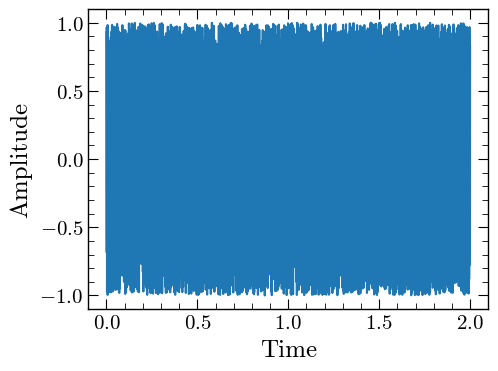

In [288]:
n_samples = 10000
white_noise = np.random.uniform(low=-1.0, high=1.0, size=n_samples)
white_noise_td = np.linspace(0,2,n_samples)

fig,ax1=pf.create_plot()
ax1.plot(white_noise_td,white_noise)
ax1.set_xlabel('Time')
ax1.set_ylabel('Amplitude')
pf.fix_plot([ax1])


min 2247.258534828062, max 2499.7499999999995
Generating stochastic comb res 0.002000200020002, nf 3, f0 2247.258534828062, df 70.57703102017716


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


True

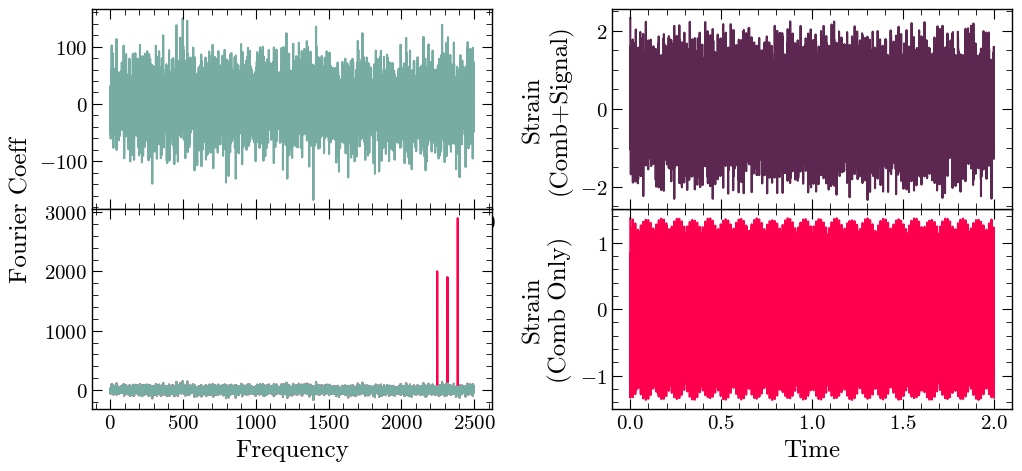

In [289]:
test = Comb3(white_noise,white_noise_td)

fig2, ax2 = pf.create_plot(size=(4,2))
ax2.plot(test.w_FD_freqs,test.w_FD_data, color='#77aca2')

ax3 = fig2.add_axes((0,-1,1,1), sharex=ax1)
ax3.plot(test.w_FD_freqs, test.i_FD_data, color='#ff004f')
ax3.plot(test.w_FD_freqs, test.w_FD_data, color='#77aca2')

ax3.set_xlabel('Frequency')
ax3.set_ylabel('Fourier Coeff')
ax3.yaxis.set_label_coords(-0.15,1)


ax4 = fig2.add_axes((1.3,-1,1,1))
ax4.set_xlabel('Time')
ax4.set_ylabel('Strain\n(Comb Only)')

ax4.plot(test.w_TD_times,test.i_TD_data_comb, color='#ff004f')

ax5 = fig2.add_axes((1.3,0,1,1), sharex=ax4)
plt.setp(ax5.get_xticklabels(), visible=False)
ax5.plot(test.w_TD_times,test.i_TD_data, color='#5C2751')
ax5.set_ylabel('Strain\n(Comb+Signal)')

pf.fix_plot([ax2,ax3,ax4,ax5])

array([ 1.32066361,  0.07837348, -1.31132446, ..., -0.23400313,
       -1.31132446,  0.07837348], shape=(10000,))